## Visualizing intermediate activations

In [1]:
from tensorflow import keras

In [9]:
model = keras.models.load_model('conv_segmantation_model')
model.summary()

Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 80, 80, 3)]       0         
_________________________________________________________________
rescaling_21 (Rescaling)     (None, 80, 80, 3)         0         
_________________________________________________________________
conv2d_147 (Conv2D)          (None, 40, 40, 64)        1792      
_________________________________________________________________
conv2d_148 (Conv2D)          (None, 40, 40, 64)        36928     
_________________________________________________________________
conv2d_149 (Conv2D)          (None, 20, 20, 128)       73856     
_________________________________________________________________
conv2d_150 (Conv2D)          (None, 20, 20, 128)       147584    
_________________________________________________________________
conv2d_151 (Conv2D)          (None, 10, 10, 256)       295

Take a new image

In [10]:
from tensorflow import keras
import numpy as np

img_path = keras.utils.get_file(fname="cat.jpg", origin="https://img-datasets.s3.amazonaws.com/cat.jpg")

In [11]:
def get_img_array(img_path, target_size):
    img = keras.utils.load_img(
    img_path, target_size=target_size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

In [12]:
img_tensor = get_img_array(img_path, target_size=(80, 80))

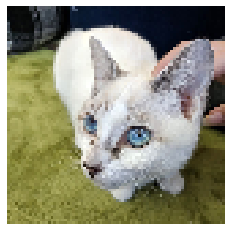

In [13]:
import matplotlib.pyplot as plt
plt.axis("off")
plt.imshow(img_tensor[0].astype("uint8"))

## Instantiating a model that returns layer activations

In [14]:
from tensorflow.keras import layers

layer_outputs = []
layer_names = []
for layer in model.layers:
    if isinstance(layer, (layers.Conv2D, layers.MaxPooling2D)):
        layer_outputs.append(layer.output)
        layer_names.append(layer.name)
activation_model = keras.Model(inputs=model.input, outputs=layer_outputs)

In [15]:
activations = activation_model.predict(img_tensor)

In [16]:
first_layer_activation = activations[0]
first_layer_activation.shape

(1, 40, 40, 64)

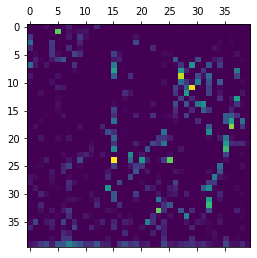

In [17]:
plt.matshow(first_layer_activation[0, :, :, 5], cmap="viridis")

ValueError: negative dimensions are not allowed

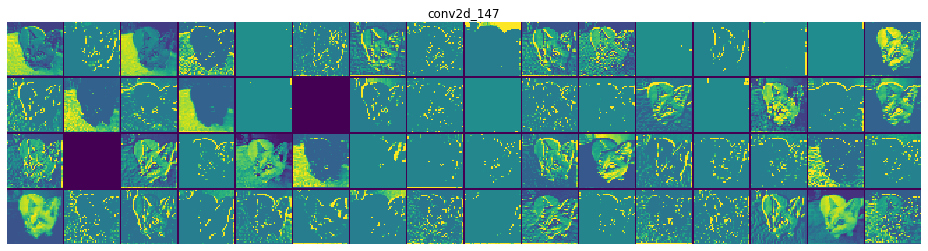

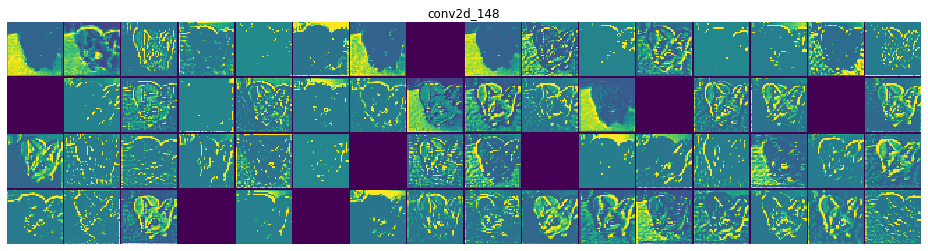

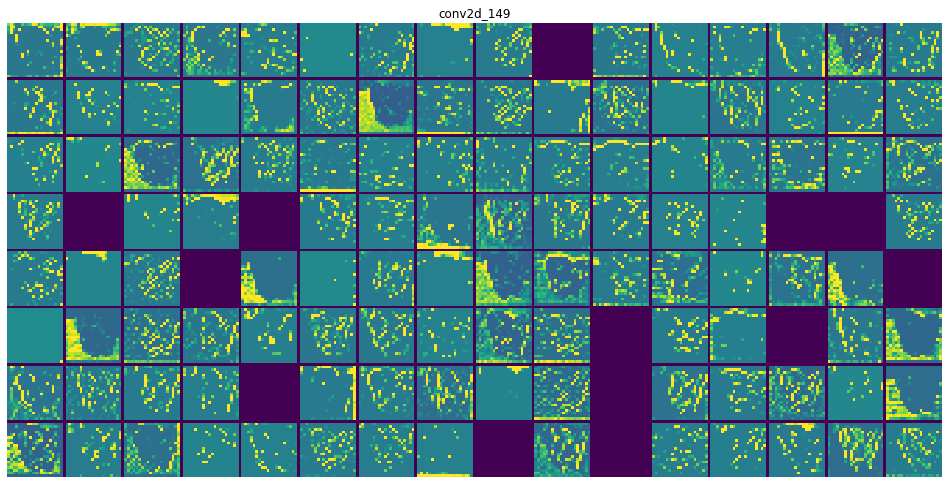

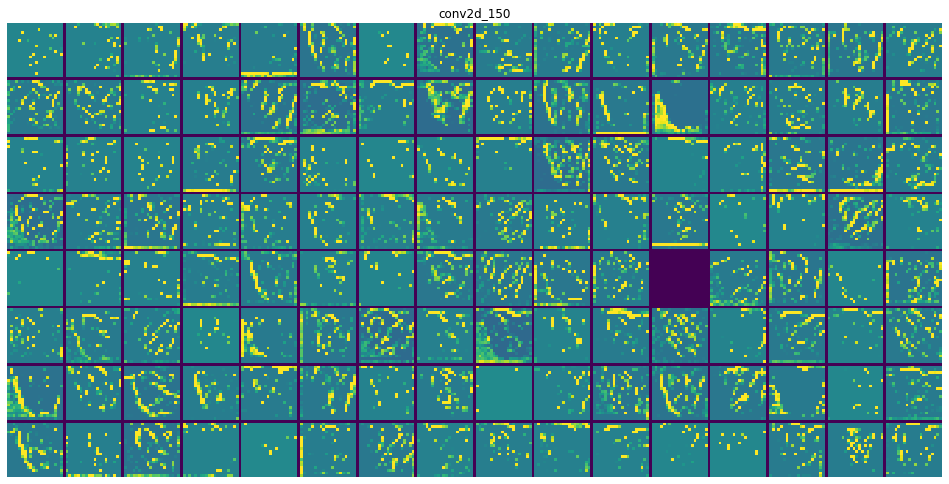

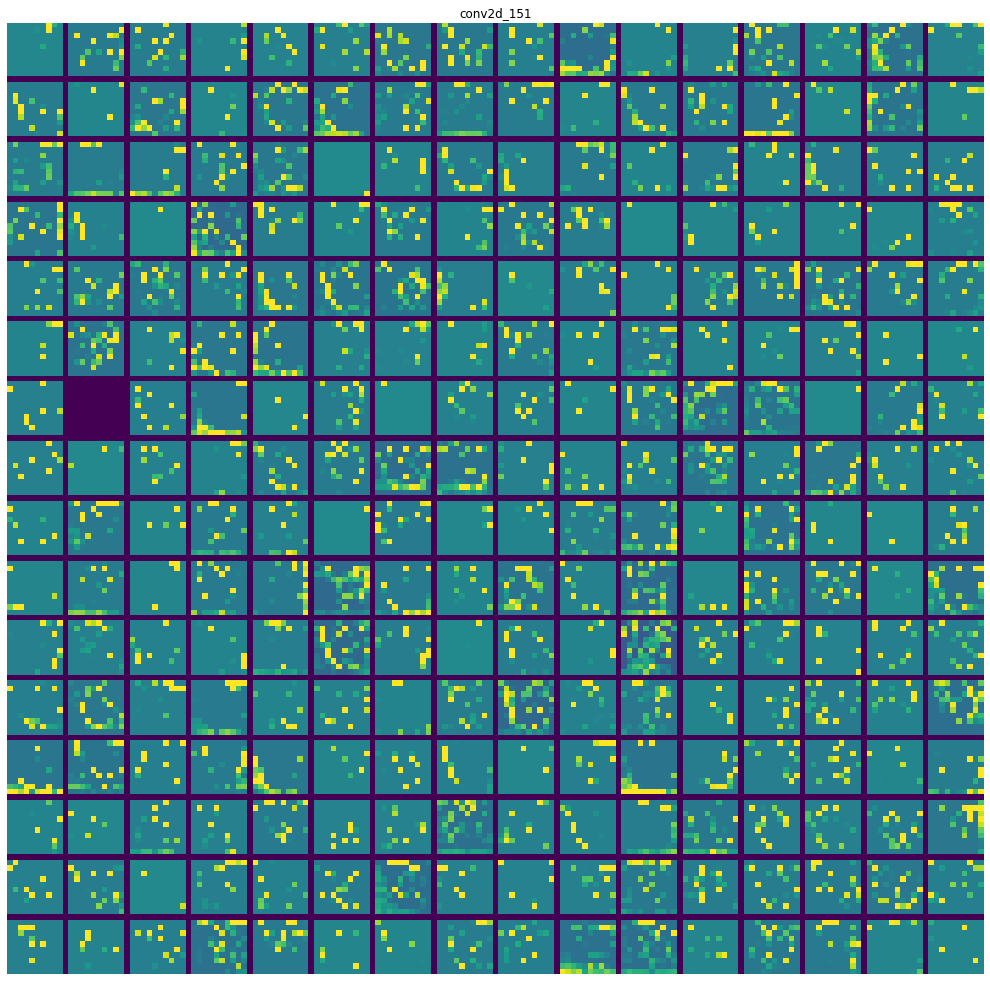

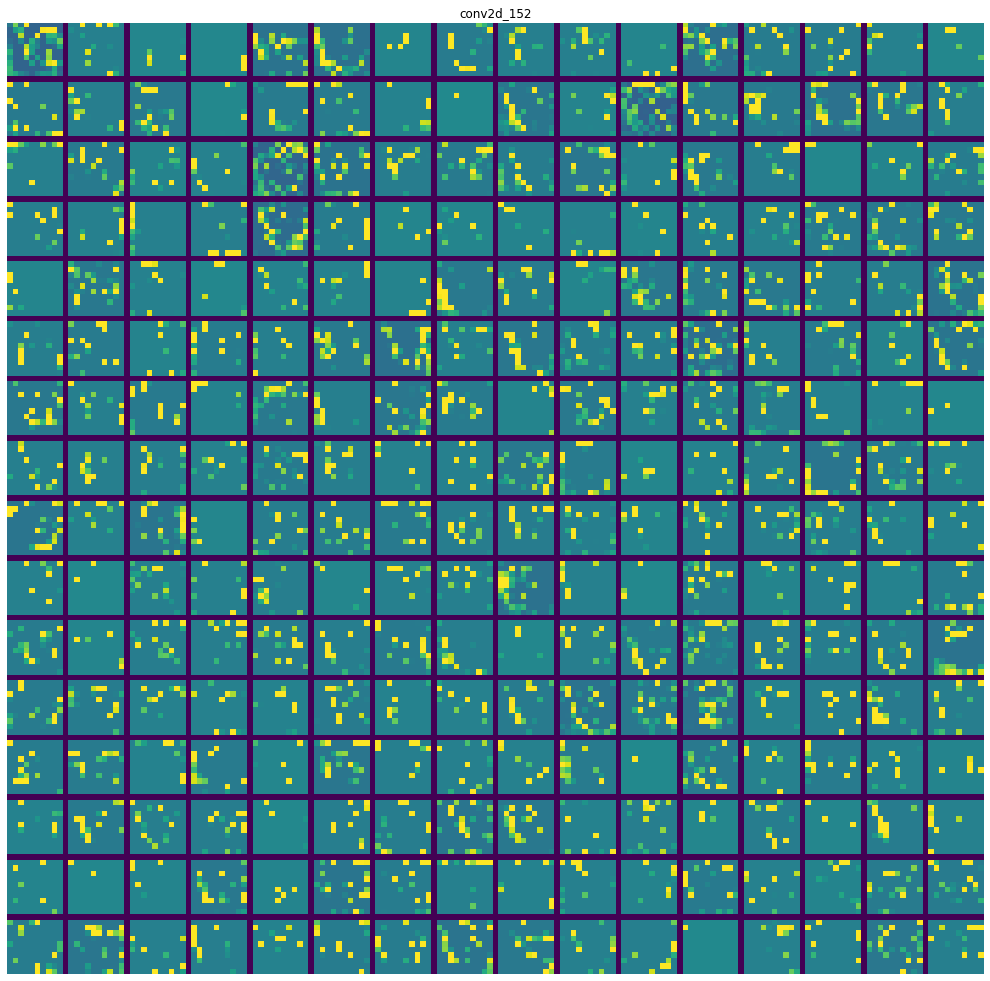

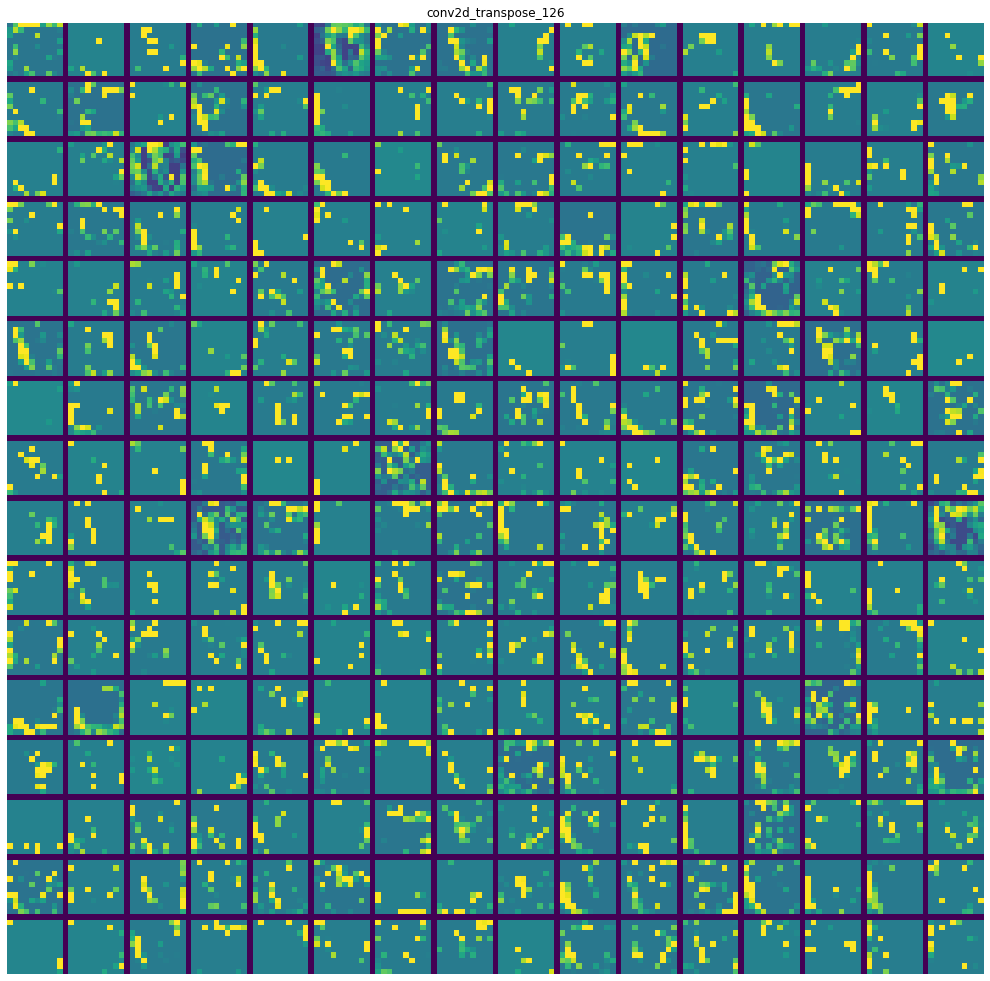

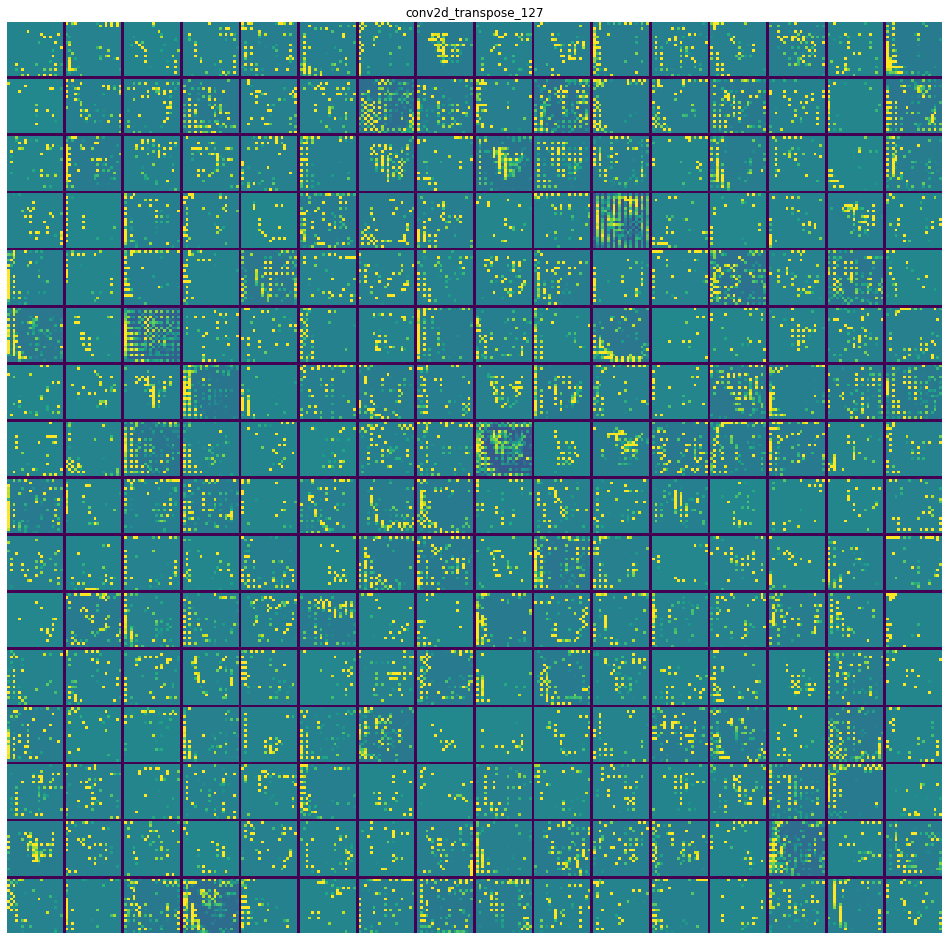

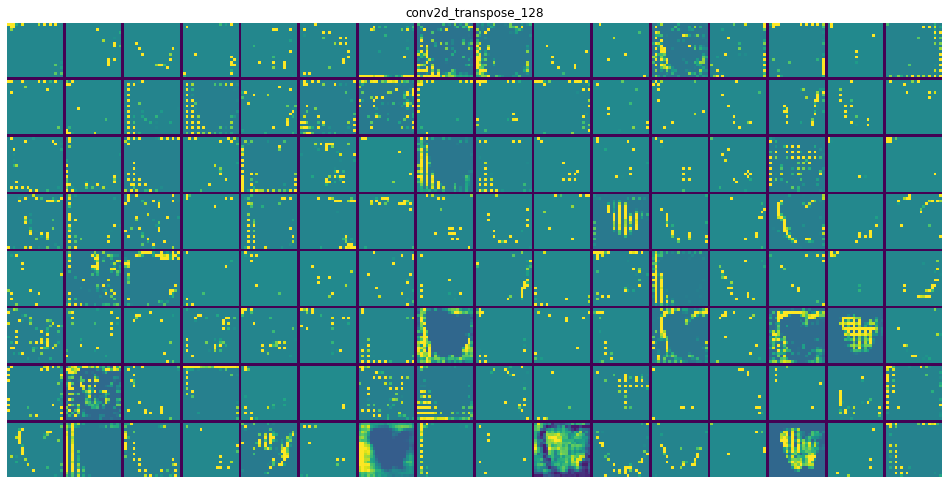

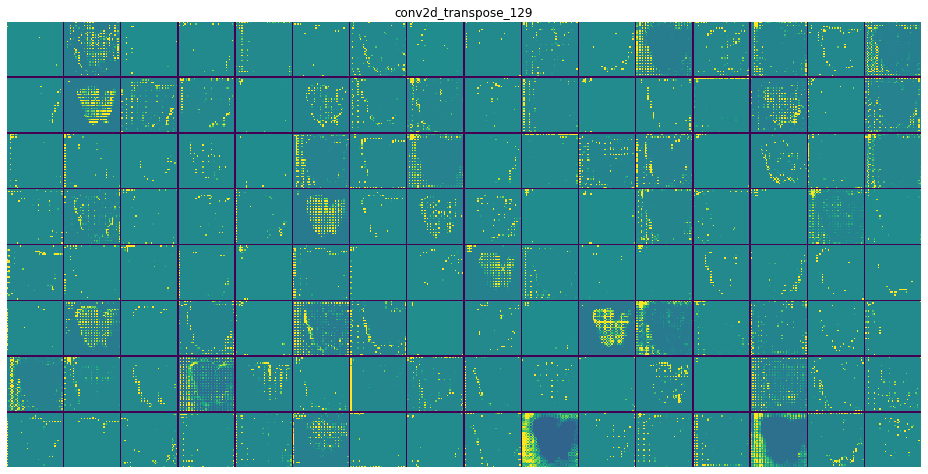

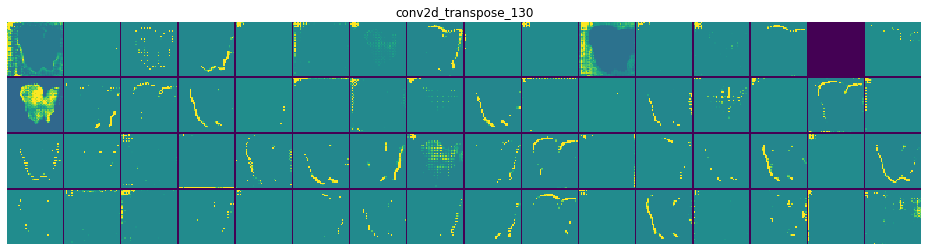

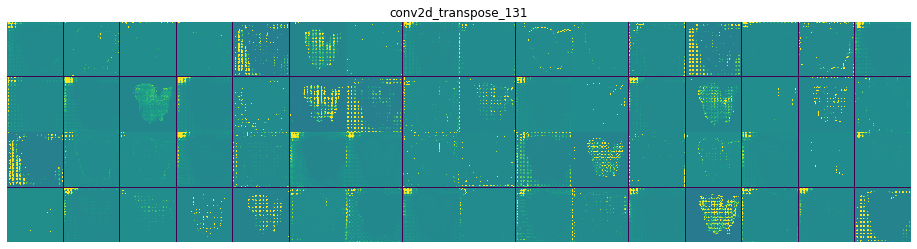

In [18]:
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros(((size + 1) * n_cols - 1, images_per_row * (size + 1) - 1))
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_index = col * images_per_row + row
            channel_image = layer_activation[0, :, :, channel_index].copy()
            
            if channel_image.sum() != 0:
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype("uint8")
            display_grid[col * (size + 1): (col + 1) * size + col, row * (size + 1) : (row + 1) * size + row] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
    scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.axis("off")
    plt.imshow(display_grid, aspect="auto", cmap="viridis")

## Visualizing convnet filters
Another easy way to inspect the filters learned by convnets is to display the visual pattern that each filter is meant to respond to. This can be done with gradient ascent in
input space: applying gradient descent to the value of the input image of a convnet so as to maximize the response of a specific filter, starting from a blank input image. The
resulting input image will be one that the chosen filter is maximally responsive to. Let’s try this with the filters of the Xception model, pretrained on ImageNet. The
process is simple: we’ll build a loss function that maximizes the value of a given filter in a given convolution layer, and then we’ll use stochastic gradient descent to adjust
the values of the input image so as to maximize this activation value. This will be our second example of a low-level gradient descent loop leveraging the GradientTape
object

In [19]:
model = keras.applications.xception.Xception(weights="imagenet", include_top=False)

83697664/83683744 [==============================] - 8s 0us/step


In [20]:
for layer in model.layers:
    if isinstance(layer, (keras.layers.Conv2D, keras.layers.SeparableConv2D)):
        print(layer.name)

block1_conv1
block1_conv2
block2_sepconv1
block2_sepconv2
conv2d
block3_sepconv1
block3_sepconv2
conv2d_1
block4_sepconv1
block4_sepconv2
conv2d_2
block5_sepconv1
block5_sepconv2
block5_sepconv3
block6_sepconv1
block6_sepconv2
block6_sepconv3
block7_sepconv1
block7_sepconv2
block7_sepconv3
block8_sepconv1
block8_sepconv2
block8_sepconv3
block9_sepconv1
block9_sepconv2
block9_sepconv3
block10_sepconv1
block10_sepconv2
block10_sepconv3
block11_sepconv1
block11_sepconv2
block11_sepconv3
block12_sepconv1
block12_sepconv2
block12_sepconv3
block13_sepconv1
block13_sepconv2
conv2d_3
block14_sepconv1
block14_sepconv2


Now, let’s create a second model that returns the output of a specific layer—a feature extractor model.



In [21]:
layer_name = "block3_sepconv1"
layer = model.get_layer(name=layer_name)
feature_extractor = keras.Model(inputs=model.input, outputs=layer.output)

In [22]:
activation = feature_extractor(keras.applications.xception.preprocess_input(img_tensor))

In [23]:
import tensorflow as tf

def compute_loss(image, filter_index):
    activation = feature_extractor(image)
    filter_activation = activation[:, 2:-2, 2:-2, filter_index]
    return tf.reduce_mean(filter_activation)

In [24]:
@tf.function
def gradient_ascent_step(image, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(image)
        loss = compute_loss(image, filter_index)
    grads = tape.gradient(loss, image)
    grads = tf.math.l2_normalize(grads)
    image += learning_rate * grads
    return image

In [25]:
img_width = 80
img_height = 80

def generate_filter_pattern(filter_index):
    iterations = 30
    learning_rate = 10.
    image = tf.random.uniform(
        minval=0.4,
        maxval=0.6,
        shape=(1, img_width, img_height, 3))
    for i in range(iterations):
        image = gradient_ascent_step(image, filter_index, learning_rate)
    return image[0].numpy()

In [26]:
def deprocess_image(image):
    image -= image.mean()
    image /= image.std()
    image *= 64
    image += 128
    image = np.clip(image, 0, 255).astype("uint8")
    image = image[25:-25, 25:-25, :]
    return image

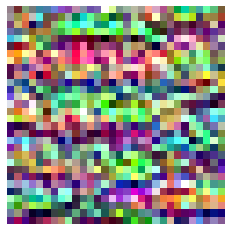

In [27]:
plt.axis("off")
plt.imshow(deprocess_image(generate_filter_pattern(filter_index=2)))

## Visualizing heatmaps of class activation

In [28]:
model = keras.applications.xception.Xception(weights="imagenet")

91897856/91884032 [==============================] - 10s 0us/step


In [29]:
img_path = keras.utils.get_file(
    fname="elephant.jpg",
    origin="https://img-datasets.s3.amazonaws.com/elephant.jpg")

def get_img_array(img_path, target_size):
    img = keras.utils.load_img(img_path, target_size=target_size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    array = keras.applications.xception.preprocess_input(array)
    return array

img_array = get_img_array(img_path, target_size=(299, 299))

745472/733657 [==============================] - 1s 1us/step


In [30]:
preds = model.predict(img_array)

In [31]:
keras.applications.xception.decode_predictions(preds, top=3)[0]

[('n02504458', 'African_elephant', 0.8699402),
 ('n01871265', 'tusker', 0.07695609),
 ('n02504013', 'Indian_elephant', 0.02354177)]

In [32]:
np.argmax(preds[0])

386

In [33]:
last_conv_layer_name = "block14_sepconv2_act"
classifier_layer_names = [
    "avg_pool",
    "predictions",
    ]
last_conv_layer = model.get_layer(last_conv_layer_name)
last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

In [34]:
classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in classifier_layer_names:
    x = model.get_layer(layer_name)(x)
classifier_model = keras.Model(classifier_input, x)

In [35]:
with tf.GradientTape() as tape:
    last_conv_layer_output = last_conv_layer_model(img_array)
    tape.watch(last_conv_layer_output)
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]
    
grads = tape.gradient(top_class_channel, last_conv_layer_output)

In [36]:
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy()
last_conv_layer_output = last_conv_layer_output.numpy()[0]
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]
heatmap = np.mean(last_conv_layer_output, axis=-1)

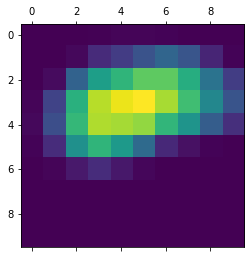

In [37]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

In [39]:
import matplotlib.cm as cm
img = keras.utils.load_img(img_path)
img = keras.utils.img_to_array(img)

heatmap = np.uint8(255 * heatmap)

jet = cm.get_cmap("jet")
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]
jet_heatmap = keras.utils.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.utils.img_to_array(jet_heatmap)
superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = keras.utils.array_to_img(superimposed_img)
save_path = "elephant_cam.jpg"
superimposed_img.save(save_path)